# Expectation model plots

## Import modules

In [1]:
# Import modules
from collections import defaultdict

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib.lines import Line2D
from scipy import stats as _stats
from sklearn.metrics import r2_score
from statsmodels.stats.proportion import proportions_ztest

%run _color_tools.ipynb

Global variables:
 	- C: color palette
 	- cm: cm to inch conversion factor


## Load data

In [2]:
# Load mutational model summary statistics
df = pd.read_csv("../outputs/observed_variants_stats_synonymous.tsv", sep="\t")

# Find the proportion of variants observed
df["obs"] = df["obs"] / df["pos"]

In [3]:
# Drop saturated contexts
nonsat = df[df["obs"] != 1].copy()

In [4]:
# Treat CpG transitions separately
ncg = nonsat[nonsat["variant_type"] != "CpG"].copy()
cpg = nonsat[nonsat["variant_type"] == "CpG"].copy()

## Color map

In [5]:
# Create colour map
col_norm = colors.LogNorm(vmin=cpg["pos"].min(), vmax=ncg["pos"].max())

# Create colour map legend
cmap = plt.cm.Blues
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        markersize=5,
        color="w",
        markerfacecolor=cmap(0.2),
        label="$10^1$",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        markersize=5,
        color="w",
        markerfacecolor=cmap(0.4),
        label="$10^2$",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        markersize=5,
        color="w",
        markerfacecolor=cmap(0.6),
        label="$10^3$",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        markersize=5,
        color="w",
        markerfacecolor=cmap(0.8),
        label="$10^4$",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        markersize=5,
        color="w",
        markerfacecolor=cmap(0.99),
        label="$10^5$",
    ),
]

## Proportion observed vs mutability

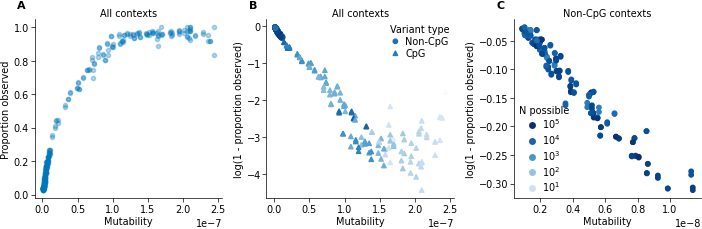

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), layout="constrained")

# Axes 0
# Plot proportion observed against mutability
axs[0].scatter(x=df["mu"], y=df["obs"], alpha=0.3)
axs[0].set_xlabel("Mutability")
axs[0].set_ylabel("Proportion observed")
axs[0].set_title("All contexts")


# Axes 1
# Plot number possible (all contexts) with a color map
axs[1].scatter(
    x=ncg["mu"],
    y=np.log(1 - ncg["obs"]),
    alpha=1,
    marker="o",
    s=10,
    label="Non-CpG",
    c=ncg["pos"],
    norm=col_norm,
    cmap="Blues",
)
axs[1].scatter(
    x=cpg["mu"],
    y=np.log(1 - cpg["obs"]),
    alpha=1,
    marker="^",
    s=10,
    label="CpG",
    c=cpg["pos"],
    norm=col_norm,
    cmap="Blues",
)
axs[1].set_title("All contexts")
axs[1].set_ylabel("log(1 - proportion observed)")
axs[1].legend(
    title="Variant type",
    labelcolor="linecolor",
)

axs[1].set_xlabel("Mutability")

# Axes 2
# Plot number possible (non-CpG contexts) with a color map
axs[2].scatter(
    x=ncg["mu"],
    y=np.log(1 - ncg["obs"]),
    alpha=1,
    marker="o",
    s=10,
    c=ncg["pos"],
    norm=col_norm,
    cmap="Blues",
)
axs[2].set_title("Non-CpG contexts")

axs[2].set_xlabel("Mutability")
axs[2].set_ylabel("log(1 - proportion observed)")

# Colormap legend
axs[2].legend(
    title="N possible",
    handles=legend_elements[::-1],
    labelcolor="black",
    loc="lower left",
    labelspacing=0.2,
)

# Add panel labels
for a, s in zip(axs, list("ABC")):
    panel_label(a, s)

# Save figures
plt.savefig("../plots/expectation_model_obs_vs_mu.svg", format="svg")
plt.savefig("../plots/expectation_model_obs_vs_mu.png", format="png", dpi=1000)

## Models

In [7]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - nonsat["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(nonsat["mu"])
w = nonsat["pos"]

# Build the model
wmodel = sm.WLS(
    y,
    X,
    weights=w,
)
wresults = wmodel.fit()

In [8]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - cpg["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(cpg["mu"])
w = cpg["pos"]

# Build the model
cpg_model = sm.WLS(
    y,
    X,
    weights=w,
)
cpg_results = cpg_model.fit()

In [9]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - ncg["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(ncg["mu"])
w = ncg["pos"]

# Build the model
ncg_model = sm.WLS(
    y,
    X,
    weights=w,
)
ncg_results = ncg_model.fit()

## Combined model vs separate models

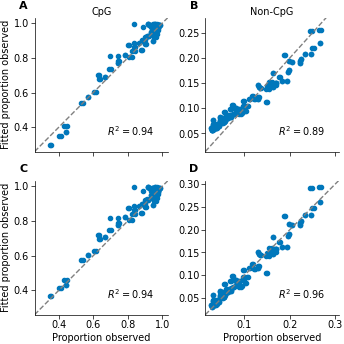

In [10]:
# Create the figure
fig, axs = plt.subplots(
    2, 2, figsize=(8.9 * cm, 8.9 * cm), layout="constrained", sharex="col"
)
axs = axs.flatten()


# Axes 0 (combined model, CpG contexts)
## Create the variables
x = cpg["obs"]
y = 1 - np.exp(wresults.predict(sm.tools.add_constant(cpg["mu"])))

## Scatter plot
axs[0].scatter(x, y)
axs[0].set_ylabel("Fitted proportion observed")
axs[0].set_title("CpG")

## Set axis limits
xy_min = min((axs[0].get_xlim()[0], axs[0].get_ylim()[0]))
xy_max = max((axs[0].get_xlim()[1], axs[0].get_ylim()[1]))
axs[0].set_xlim(xy_min, xy_max)
axs[0].set_ylim(xy_min, xy_max)

## Add x = y line
axs[0].axline((0, 0), slope=1, color="grey", linestyle="--")

## Add R2 value
axs[0].text(
    0.9,
    0.1,
    f"$R^2 = {r2_score(x,y):.2f}$",
    transform=axs[0].transAxes,
    ha="right",
    va="bottom",
)


# Axes 1 (combined model, non-CpG contexts)
## Create the variables
_x = ncg["obs"]
_y = 1 - np.exp(wresults.predict(sm.tools.add_constant(ncg["mu"])))

## Scatter plot
axs[1].scatter(_x, _y)
axs[1].set_title("Non-CpG")

## Set axis limits
xy_min = min((axs[1].get_xlim()[0], axs[1].get_ylim()[0]))
xy_max = max((axs[1].get_xlim()[1], axs[1].get_ylim()[1]))
axs[1].set_xlim(xy_min, xy_max)
axs[1].set_ylim(xy_min, xy_max)

## Add x = y line
axs[1].axline((0, 0), slope=1, color="grey", linestyle="--")

## Add R2 value
axs[1].text(
    0.9,
    0.1,
    f"$R^2 = {r2_score(_x,_y):.2f}$",
    transform=axs[1].transAxes,
    ha="right",
    va="bottom",
)

# Axes 2 (CpG contexts, separate model)
## Create the variables
x = cpg["obs"]
y = 1 - np.exp(cpg_results.predict(sm.tools.add_constant(cpg["mu"])))

## Scatter plot
axs[2].scatter(x, y)
axs[2].set_xlabel("Proportion observed")
axs[2].set_ylabel("Fitted proportion observed")
# axs[2].set_title("CpG")

## Set axis limits
xy_min = min((axs[2].get_xlim()[0], axs[2].get_ylim()[0]))
xy_max = max((axs[2].get_xlim()[1], axs[2].get_ylim()[1]))
axs[2].set_xlim(xy_min, xy_max)
axs[2].set_ylim(xy_min, xy_max)

## Add x = y line
axs[2].axline((0, 0), slope=1, color="grey", linestyle="--")

## Add R2 value
axs[2].text(
    0.9,
    0.1,
    f"$R^2 = {r2_score(x,y):.2f}$",
    transform=axs[2].transAxes,
    ha="right",
    va="bottom",
)


# Axes 3 (non-CpG contexts, separate model)
## Create the variables
_x = ncg["obs"]
_y = 1 - np.exp(ncg_results.predict(sm.tools.add_constant(ncg["mu"])))

## Scatter plot
axs[3].scatter(_x, _y)
axs[3].set_xlabel("Proportion observed")

## Set axis limits
xy_min = min((axs[3].get_xlim()[0], axs[3].get_ylim()[0]))
xy_max = max((axs[3].get_xlim()[1], axs[3].get_ylim()[1]))
axs[3].set_xlim(xy_min, xy_max)
axs[3].set_ylim(xy_min, xy_max)

## Add x = y line
axs[3].axline((0, 0), slope=1, color="grey", linestyle="--")

## Add R2 value
axs[3].text(
    0.9,
    0.1,
    f"$R^2 = {r2_score(_x,_y):.2f}$",
    transform=axs[3].transAxes,
    ha="right",
    va="bottom",
)

# Panel labels
for a, s in zip(axs, list("ABCD")):
    panel_label(a,s)

# Save figures
plt.savefig("../plots/expectation_model_joint_vs_separate.svg", format="svg")
plt.savefig("../plots/expectation_model_joint_vs_separate.png", format="png", dpi=1000)